# Thorium Calibration

We simulate a thorium mantle attached next to the tank. We calculate the expected spectrum for the energy deposition as well as the rate of incidence.

In [1]:
#Include modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from accelerate import parallel, concat
from tqdm.notebook import tqdm

%matplotlib widget

In [2]:
# Read the files

# Parameters
run                     = 'run3'
header                  = ['EventID','TrackID','Particle','EnergyDeposited','XPosition','YPosition','ZPosition','LocalTime','Volume']

# Find the files
foldername  = f'./data/{run}/output'
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}')

def loadFile(filename):
    return pd.read_csv(os.path.join(foldername,filename),skiprows=14,names=header)

loadFiles = parallel(loadFile)

if __name__ == '__main__':
    files = loadFiles(filenames)

Found 1024 data files in ./data/run3/output
100%|██████████| 1024/1024 [00:00<00:00, 1226.64it/s]


In [3]:
# Function to extract the energy deposited per track
def getEnergy(data):
    return data.groupby(['EventID','TrackID','Particle'])['EnergyDeposited'].sum().reset_index()

getEnergies = concat(parallel(getEnergy))

# Get the incoming energy of the particles

# Get the deposited energies
energy = getEnergies(files)

# Split into the energy per particle
particleEnergies = {particle:energy.loc[energy.Particle.str.contains(particle)] for particle in energy.Particle.unique()}



100%|██████████| 1024/1024 [00:01<00:00, 659.32it/s]


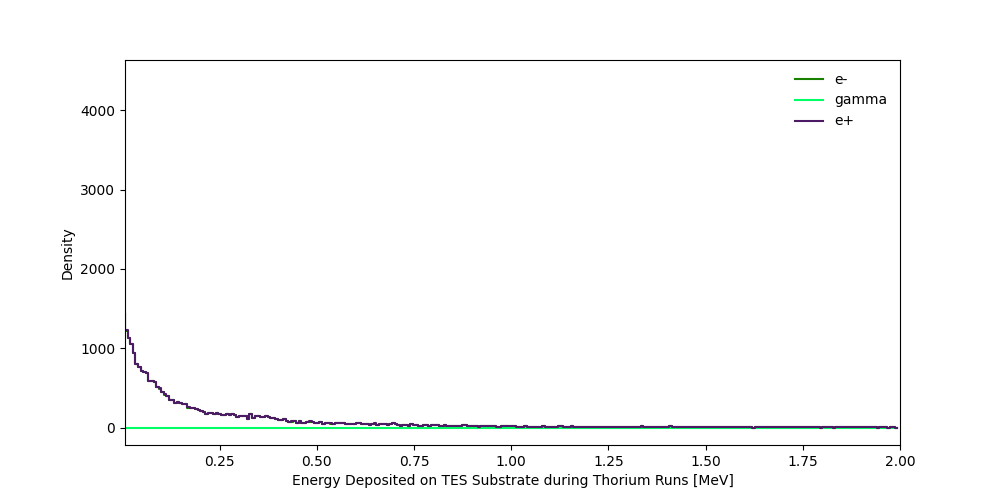

In [4]:
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 300
LIMS        = (0,2)
BINS        = np.linspace(*LIMS,NBINS+1)
stackedHist = np.array([np.histogram(particleEnergies[particle].EnergyDeposited,bins=BINS)[0] for particle in particleEnergies])
color       = np.round(np.random.rand(len(stackedHist),3),1)
[ax.step(BINS[:-1],hist,label=particle,color=c) for hist,particle,c in zip(stackedHist,particleEnergies,color)]

ax.set_xlim(BINS[1],2)
# ax.set_ylim(0,np.max(,axis=0))
ax.set_xlabel('Energy Deposited on TES Substrate during Thorium Runs [MeV]')
ax.set_ylabel('Density')
ax.legend(frameon=False)
# ax.set_yscale('log')
# ax.set_xscale('log')

In [5]:
len(particleEnergies['gamma'].EnergyDeposited) /len(energy)

0.0287569573283859

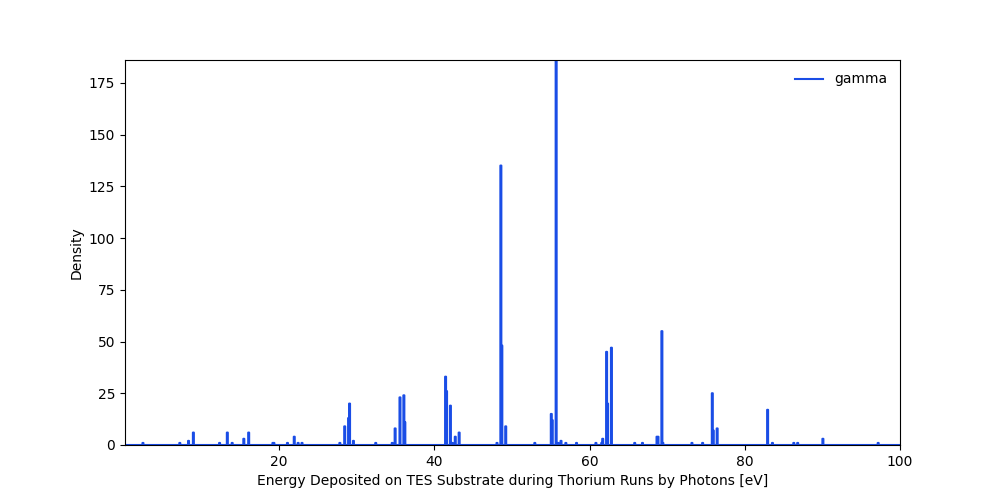

In [6]:
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 800
LIMS        = (0,0.0001)
BINS        = np.linspace(*LIMS,NBINS+1)
PARTICLE    = 'gamma'
stackedHist = np.histogram(particleEnergies[PARTICLE].EnergyDeposited,bins=BINS)[0]
color       = np.round(np.random.rand(len(stackedHist),3),1)
ax.step(BINS[:-1]*1e6,stackedHist,label=PARTICLE,color=color[0])

ax.set_xlim(BINS[1]*1e6,BINS[-1]*1e6)
ax.set_ylim(0,np.max(stackedHist[1:]))
ax.set_xlabel('Energy Deposited on TES Substrate during Thorium Runs by Photons [eV]')
ax.set_ylabel('Density')
ax.legend(frameon=False)
# ax.set_yscale('log')
# ax.set_xscale('log')